## **WRF-IGP WORK ASSIGMENT #1** 

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import integrate
import cmocean as cmo
import xarray as xr
import imageio
import os
plt.style.use('seaborn')

<h2><strong>Parameters</strong></h2>

In [404]:
wind_speed = 7*1e-3
wind_direc = 140
dx = dy = 18
time_step  = 0.04
uwind = -np.cos(np.deg2rad(wind_direc))*wind_speed
vwind = -np.sin(np.deg2rad(wind_direc))*wind_speed

In [405]:
T = np.array([[21.2, 22.8, 23.5, 24.8, 26.5], 
              [22.7, 24.4, 25.2, 26.5, 28.4], 
              [24.3, 26.1, 27.0, 28.4, 30.4], 
              [26.0, 27.9, 28.9, 30.4, 32.5],
              [27.8, 29.9, 30.9, 32.5, 34.8],
              [29.7, 32.0, 33.0, 34.8, 37.2], 
              [31.8, 34.2, 35.3, 37.2, 39.8]])

## **Time step**

## $\frac{C*\Delta t}{\Delta r} \le 0.06$

In [406]:
tstep = lambda ws, wd, dx, dy: round(0.06*dx/ws*abs((np.cos(np.deg2rad(wd)))) + 
                                     0.06*dy/ws*abs(np.sin(np.deg2rad(wd))),2)
time_step = tstep(wind_speed, wind_direc, dx, dy)
print(f'Our time step must be less than {time_step} seconds')

Our time step must be less than 217.36 seconds


## **Choosing** $\Delta t = 200s$

In [419]:
time_step = 200

In [420]:
N = round(3600/time_step)+1
print(f'Total N simulation is {N}')

Total N simulation is 19


## **Total derivative for Temperature**

<h1>$$\frac{\partial T}{\partial t} = u\frac{\partial T}{\partial x} + v\frac{\partial T}{\partial y}$$</h1>

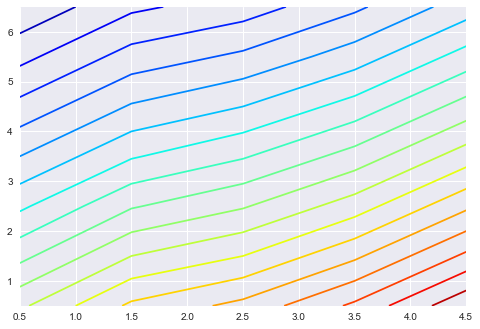

In [435]:
plt.contour(T, levels=21, cmap='jet', origin='upper')

In [430]:
T

array([[21.2, 22.8, 23.5, 24.8, 26.5],
       [22.7, 24.4, 25.2, 26.5, 28.4],
       [24.3, 26.1, 27. , 28.4, 30.4],
       [26. , 27.9, 28.9, 30.4, 32.5],
       [27.8, 29.9, 30.9, 32.5, 34.8],
       [29.7, 32. , 33. , 34.8, 37.2],
       [31.8, 34.2, 35.3, 37.2, 39.8]])

In [429]:
np.gradient(T)

[array([[1.5 , 1.6 , 1.7 , 1.7 , 1.9 ],
        [1.55, 1.65, 1.75, 1.8 , 1.95],
        [1.65, 1.75, 1.85, 1.95, 2.05],
        [1.75, 1.9 , 1.95, 2.05, 2.2 ],
        [1.85, 2.05, 2.05, 2.2 , 2.35],
        [2.  , 2.15, 2.2 , 2.35, 2.5 ],
        [2.1 , 2.2 , 2.3 , 2.4 , 2.6 ]]),
 array([[1.6 , 1.15, 1.  , 1.5 , 1.7 ],
        [1.7 , 1.25, 1.05, 1.6 , 1.9 ],
        [1.8 , 1.35, 1.15, 1.7 , 2.  ],
        [1.9 , 1.45, 1.25, 1.8 , 2.1 ],
        [2.1 , 1.55, 1.3 , 1.95, 2.3 ],
        [2.3 , 1.65, 1.4 , 2.1 , 2.4 ],
        [2.4 , 1.75, 1.5 , 2.25, 2.6 ]])]

In [421]:
DTdt = np.array([T]*N)    

In [422]:
def eulerm(f,dx,dy,dt,u,v):
    dTdy,dTdx = np.gradient(f, dy,dx)
    dTdy = -dTdy
    F = f+dt*(u*dTdx+v*dTdy)
    return F

In [423]:
for n in range(N-1):
    DTdt[n+1,:,:] = eulerm(DTdt[n,:,:],dx,dy,time_step,uwind,vwind)

In [514]:
#------------------
# Gradients
#------------------
DTdy = -np.array([np.gradient(DTdt[n,:,:])[0] for n in range(DTdt.shape[0])])
DTdx = np.array([np.gradient(DTdt[n,:,:])[1] for n in range(DTdt.shape[0])])
X,Y = np.meshgrid(np.arange(7), np.arange(5))

In [518]:
%%capture
def temp_advect_plot(n,N):
    fig, ax = plt.subplots(figsize=(10,6), dpi=80)
    pls = ax.contourf(DTdt[n,:,:], levels=np.linspace(20,45,60, endpoint=True), cmap=cmo.cm.delta, 
                      zorder=1, vmin=20, vmax=45, origin='upper')
    CS  = ax.contour(DTdt[n,:,:], levels=12, zorder=2, linewidths=0.6, colors='black', 
                     vmin=20, vmax=45, origin='upper')
    ax.clabel(CS, CS.levels, inline=True, fontsize=8, fmt='%1.1f', colors='black')
    ax.grid(linestyle='--',color='gray',alpha=0.5)
    ax.set(xlabel='X axis', ylabel='Y axis') 
    ax.set_title(f'Time={N} seconds', loc='left')
    ax.set_title('C.E.O', loc='right')
    ax.set_xticklabels(np.arange(0,5,.5))
    ax.set_yticklabels(np.arange(0,7,1))
    colorbar_ax = fig.add_axes([0.91, 0.125, 0.035, 0.755])
    fig.colorbar(pls, cax=colorbar_ax, aspect=15, label='Temperature (ºC)', ticks=np.arange(20,45,4))
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./Temp_advect_HW1_CEO.gif', 
                [temp_advect_plot(n, N) for n,N in enumerate(np.arange(0,3600+1,time_step))], fps=1)